# **Predicting Subscription Status Based on Player Characteristics**

### Data Science 100 Project - Group 10

- Kyle Nguyen (76276393)
- Jiayin Wang (47186200)
- Clianta Anindya (78508892)


## **Introduction**

### Background Information
In recent years, the gaming industry has increasingly relied on data to better understand player behavior and improve user engagement.
One area of interest is predicting which players are most likely to subscribe to game-related newsletters, as this can inform targeted recruitment strategies, optimize resource allocation, and improve community building around gaming platforms.

Our group is addressing Question 1 from the project brief: _What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?_

To explore this, we focus specifically on whether player age, total hours played and session count can predict whether a player subscribed to the newsletter. The first two variables are available in the **_players.csv_** dataset (**_Age_** and **_played_hours_**, respectively) while the session count variable will be taken from the sum of the number of rows in the **_sessions.csv_** dataset for each hashed email that is unique per player.

Understanding how these player characteristics relate to newsletter subscription behavior could help stakeholders improve how they engage different player types, and may also provide insights into motivations behind long-term or more invested gameplay.

### Questions
- **Broad question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
- **Specific question**: Can **_age_**, **_played_hours_**, and **_session_count_** predict **_subscribe_** in the data set?
### Description of data sets used

This project is based on data collected by a research group at UBC, led by Professor Frank Wood. The group operates a Minecraft research server (_plaicraft.ai_) where they track how users interact within the virtual world.

We will be using the **players.csv** and **sessions.csv** datasets.

The **players.csv** set has 196 rows, each representing one player, uniquely identified by _hashedEmail_.
There are 7 variables in the **players.csv** data set:
* _experience_: character, indicating player's experience level
* _hashedEmail_: character, unique identifier for each player
* _name_: character, player's name
* _gender_: character, player's gender
* _played_hours_: double, total hour the player has played
* _Age_: double, player's age
* _subscribe_: logical, whether the player subscribes the newsletter

The **sessions.csv** set has 1535 rows, each representing one play session.
There are 5 variables in the **session.csv** data set:
* _hashedEmail_: character, unique identifier connecting session to a player
* _start_time_: character, start time in DD/MM/YYYY HH:MM format
* _end_time_: character, end time in DD/MM/YYYY HH:MM format
* _original_start_time_: double, unix timestamp of start time
* _original_end_time_: double, unix timestamp of end time

## **Methods and Results**

#### Library Loading
Firstly, we loaded the libraries and set row view limit before continuing. The package startup messages are suppressed with with suppressMessages() for cleanliness.

In [1]:
suppressMessages(library(repr))
suppressMessages(library(tidyverse))
suppressMessages(library(tidymodels))
suppressMessages(library(cowplot))

options(repr.matrix.max.rows = 6)

#### Data Loading
Next, we read the csv files to their corresponding dataframe variable. We also suppressed read_csv() messages with suppressMessages() for cleanliness.

In [2]:
players <- suppressMessages(read_csv("data/players.csv"))
sessions <- suppressMessages(read_csv("data/sessions.csv"))

#### Data Wrangling and Cleaning
To wrangle and clean the data before analsis, we grouped the **_sessions_** dataframe by _hashedEmail_ and summarized the count of rows aggregated per group, and assigned it to **_sessions_formatted_**. Then, we left-joined the **_players_** dataframe to **_sessions_formatted_** via _hashedEmail_ to retain all the players rows. All blank _session_counts_ are replaced with 0 as we observed that all players with blank _session_counts_ have a 0 for _played_hours_. We renamed '_Age_' to '_age_' for lowercase consistency in the variables. Then, we converted '_subscribe_' to a factor via as.factor(). Only the desired exploratory variables and response variable were selected to be viewed. Rows with a blank age were filtered out as we only observed 2 NAs in the '_age_' column. Lastly, the rows were arranged in ascending order for age, then played_hours, then session_count in the final tidied dataframe **_players_tidy_**.

In [3]:
sessions_formatted <- group_by(sessions, hashedEmail) |>
    summarize(session_count = n())

players_tidy <- left_join(players, sessions_formatted, by = "hashedEmail") |>
    mutate(session_count = replace_na(session_count, 0)) |>
    rename(age = Age) |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(age, played_hours, session_count, subscribe) |>
    filter(!is.na(age)) |>
    arrange(age, played_hours, session_count)

players_tidy

age,played_hours,session_count,subscribe
<dbl>,<dbl>,<int>,<fct>
8,0.3,1,TRUE
9,30.3,27,TRUE
10,3.6,7,TRUE
⋮,⋮,⋮,⋮
46,0.0,0,FALSE
49,18.5,16,TRUE
50,0.0,1,FALSE


#### Summary Statistics of the Data Set
A mean summary statistics of variables in the tidied dataframe is displayed below.

In [4]:
players_means <- players_tidy |> 
    summarize(mean_age = mean(age, na.rm = TRUE),
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        mean_session_count = mean(session_count, na.rm = TRUE))

players_means

mean_age,mean_played_hours,mean_session_count
<dbl>,<dbl>,<dbl>
20.52062,5.904639,7.902062


#### Dataset Visualizations 
We created three _Y vs. X_ 2D scatter plots based on the cleaned and joined data frame, **_player_tidy_**, to preliminarily explore the relationship between the three variables. Colors were assigned to the plot points based on the player subscription status.

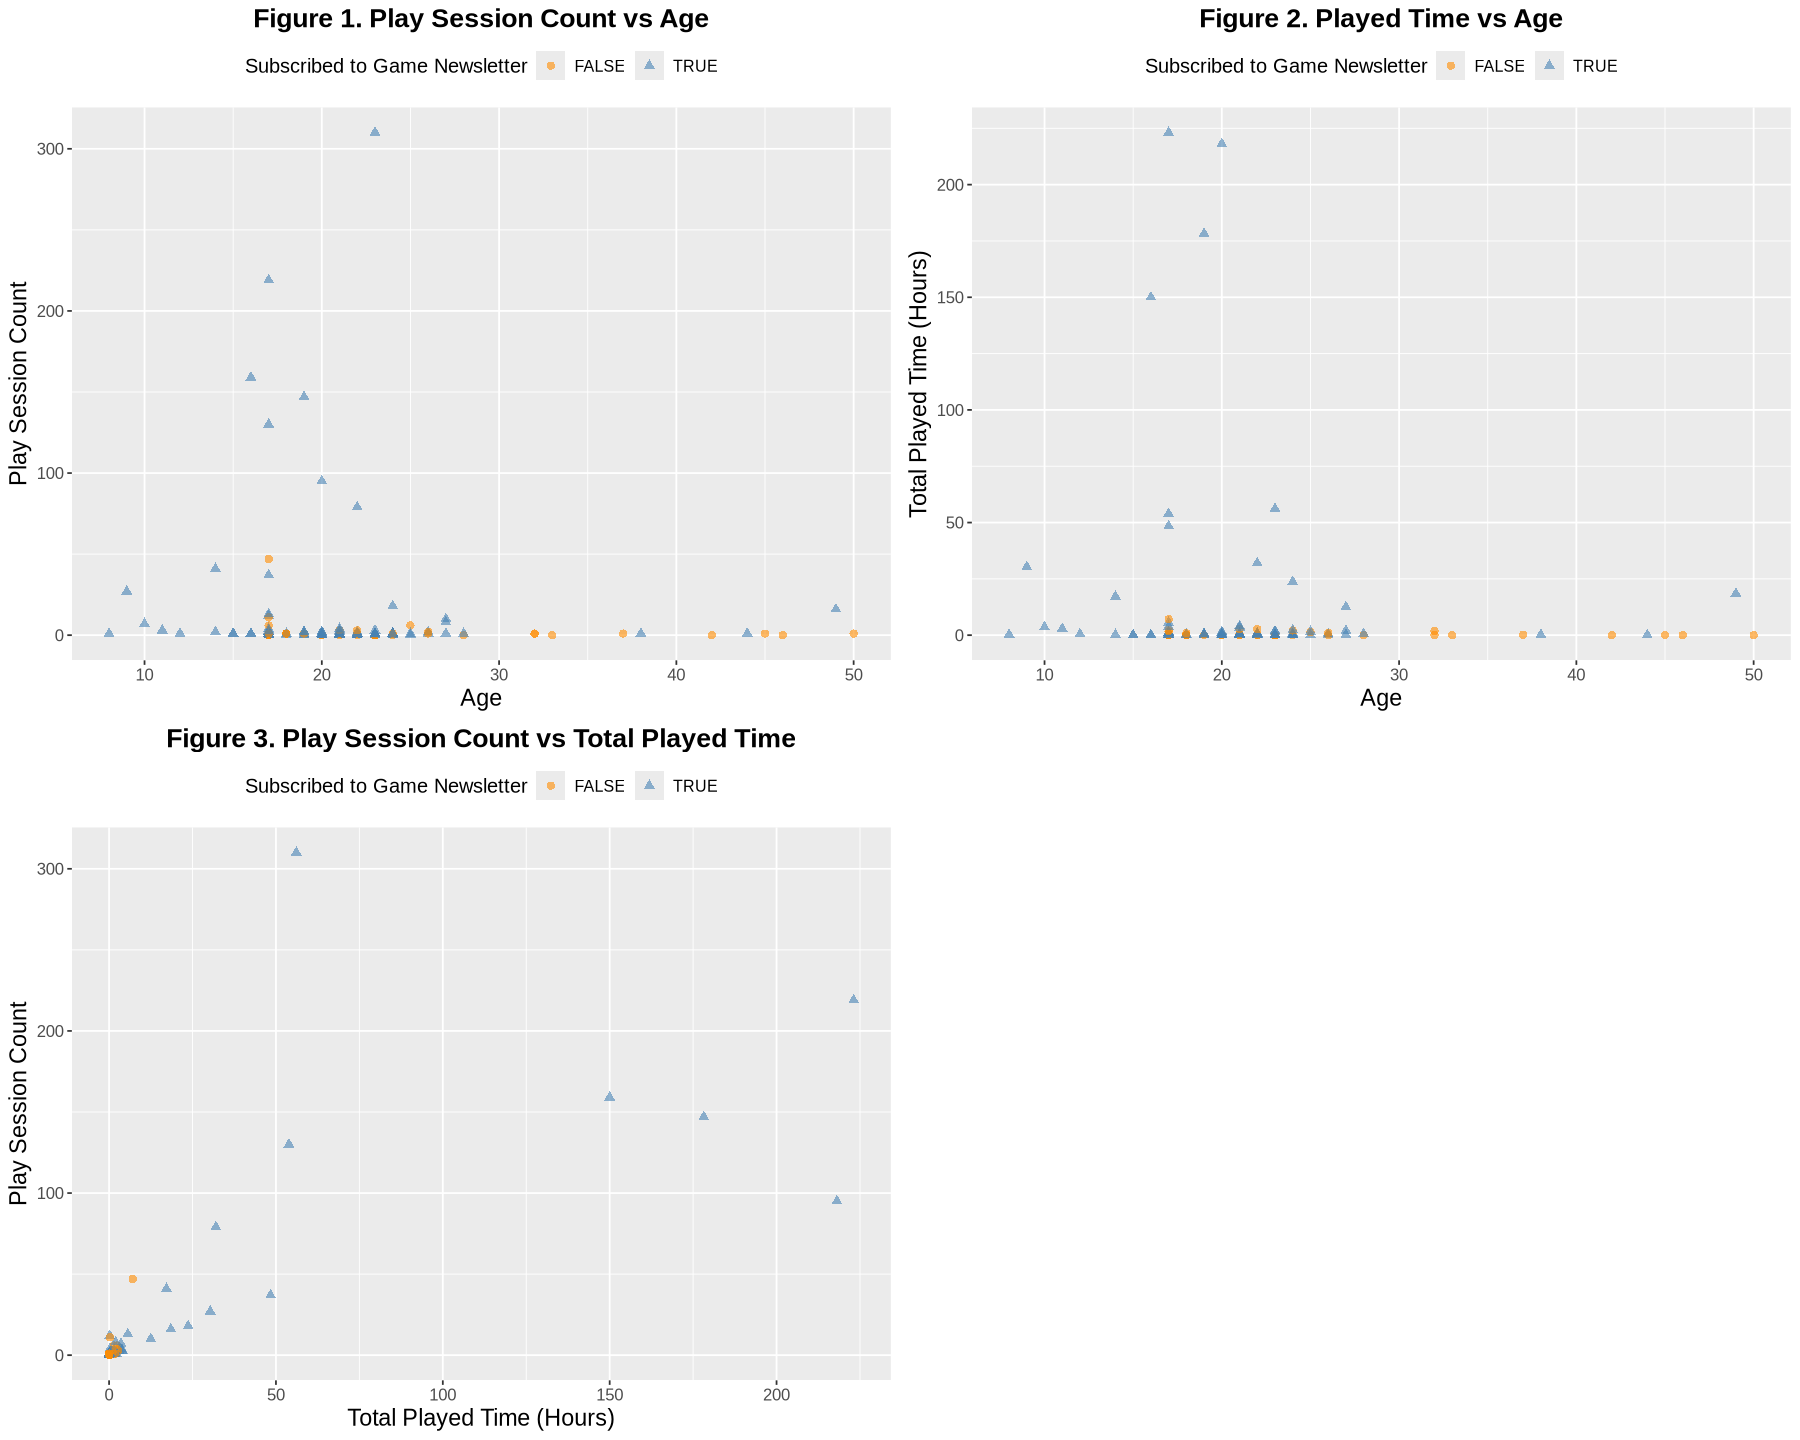

In [5]:
options(repr.plot.width = 15, repr.plot.height = 12)

plot1 <- ggplot(players_tidy, aes(x = age, y = session_count, color = subscribe, shape = subscribe)) +
    geom_point(alpha = 0.6, size = 2) +
    labs(
        title = "Figure 1. Play Session Count vs Age",
        x = "Age",
        y = "Play Session Count",
        color = "Subscribed to Game Newsletter",
        shape = "Subscribed to Game Newsletter"
    ) +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(
        text = element_text(size = 12),
        legend.position = "top",
        plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14)
    )

plot2 <- ggplot(players_tidy, aes(x = age, y = played_hours, color = subscribe, shape = subscribe)) +
    geom_point(alpha = 0.6, size = 2) +
    labs(
        title = "Figure 2. Played Time vs Age",
        x = "Age",
        y = "Total Played Time (Hours)",
        color = "Subscribed to Game Newsletter",
        shape = "Subscribed to Game Newsletter"
    ) +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(
        text = element_text(size = 12),
        legend.position = "top",
        plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14)
    )

plot3 <- ggplot(players_tidy, aes(x = played_hours, y = session_count, color = subscribe, shape = subscribe)) +
    geom_point(alpha = 0.6, size = 2) +
    labs(
        title = "Figure 3. Play Session Count vs Total Played Time",
        x = "Total Played Time (Hours)",
        y = "Play Session Count",
        color = "Subscribed to Game Newsletter",
        shape = "Subscribed to Game Newsletter"
    ) +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(
        text = element_text(size = 12),
        legend.position = "top",
        plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14)
    )

scatterplot_panel <- plot_grid(plot1, plot2, plot3, ncol = 2)

scatterplot_panel

#### Splitting Data into Training and Testing Sets
The **_players_tidy_** dataframe was split into training:testing sets with an 80:20 ratio.

In [6]:
set.seed(1234)
split <- initial_split(players_tidy, prop = 0.8)
training <- training(split)
testing <- testing(split)

#### K Parameter Value Selection

To determine the optimal value for the K neighbors parameter to use in our model, 5-fold cross-validation was used to calculate the accuracy for several K values within a reasonable range. We made sure to should perform some scaling and centering preprocessing on the predictor variables in the training set to standardize them before continuing with cross-validation on the training set. We then plotted a mean estimated accuracy vs. K plot in **Figure 4** to decide which number of neighbors is best. Based on the plot, we choose K = 6 as our optimal K to use since at K = 6, accuracy reaches a peak.

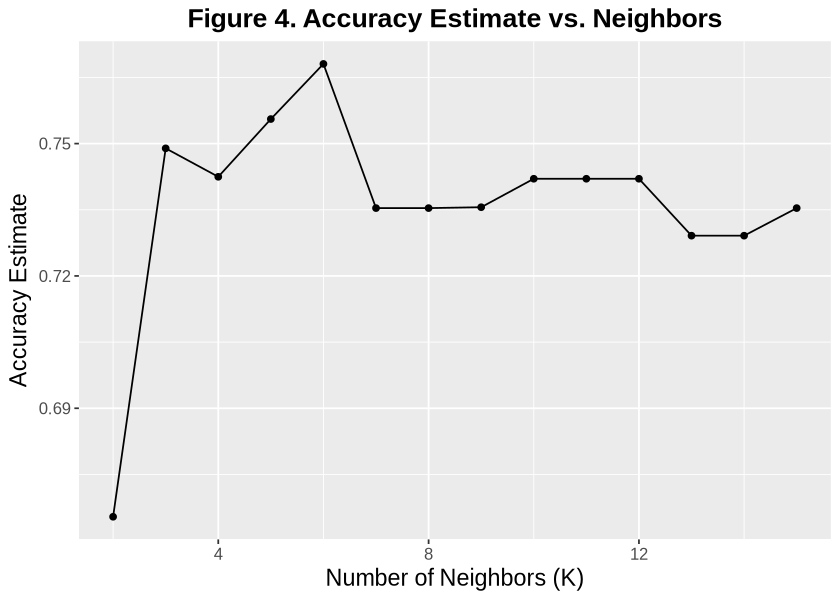

In [7]:
set.seed(9999) 
options(repr.plot.height = 5, repr.plot.width = 7)

knn_recipe <- recipe(subscribe ~ age + played_hours + session_count, data = training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

c_vfold <- vfold_cv(training, v=5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from=2, to=15, by=1))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resample = c_vfold, grid = knn_grid) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean)) |>
    drop_na()

accuracy_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(
        title = "Figure 4. Accuracy Estimate vs. Neighbors",
        x = "Number of Neighbors (K)",
        y = "Accuracy Estimate") +
    theme(
        text = element_text(size = 12),
        legend.position = "top",
        plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 14)
    )

accuracy_vs_k_plot

#### Build K-nn Model
We built the K-nn model using the optimal K identified.

In [8]:
set.seed(9999) 

player_spec <- nearest_neighbor(weight = "rectangular", neighbors = 6) |>
        set_engine("kknn") |>
        set_mode("classification")
player_fit <- workflow() |>
    add_model(player_spec) |>
    add_recipe(knn_recipe) |>
    fit(data = training)
player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2387097
Best kernel: rectangular
Best k: 6

#### Test the model
Use the testing set to test the model. Then, use accuracy confusion matrix to evalute the model performance.

In [9]:
player_predictions <- predict(player_fit, testing) |>
  bind_cols(testing)

player_metrics <- player_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

player_conf_mat <- player_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

player_metrics
player_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7948718


          Truth
Prediction FALSE TRUE
     FALSE     4    1
     TRUE      7   27

### **Discussions**

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

- Treated as a multi-class classification problem with age, session count and total playtime, although age may seem to be an irrelevant predictor compared to the other two predictors. May ask a new question whether playtime and session count affects player subscription status, omitting age, and using a binary k-nn classification model.